In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from skimage import io
from PIL import Image
import csv

In [41]:
EPOCH = 30                # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 12
INPUT_SIZE = 227         # img input size
LR = 0.001               # learning rate
DOWNLOAD_MNIST = False   # set to True if haven't download the data
TEST = False

In [42]:
class GroceryDataset(Dataset):
    data_transform = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
    """Frocery dataset."""    
    def __init__(self, mode = 'train', file = 0, \
                 transform = data_transform):
        self.fpath = '/hostname/freiburg_groceries_dataset/'
        if mode == 'train':
            file_path = self.fpath + 'splits/train{}.txt'.format(file)
            print('Training file: ', file_path)
        elif mode == 'test':
            file_path = self.fpath + 'splits/test{}.txt'.format(file)
            print('Testing file: ', file_path)
            
        # Get class id as same as which pytorch does
        class_path = os.path.join(self.fpath + 'images/')        
        classes = [d for d in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, d))]
        classes.sort()
        self.cls = {classes[i]: i for i in range(len(classes))}
        print(self.cls)
        with open(file_path) as f:
            self.flines = f.readlines()
            
        self.length = len(self.flines)
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        fsplit = self.flines[idx].split(' ')
        #print fsplit[1], fsplit[2]
        label = torch.tensor(int((self.cls[fsplit[0].split('/')[0]])))
        #print('label: ', label)
        #label = fsplit[1]
        image_path = self.fpath + 'images/' + fsplit[0]
        img = self.transform(Image.open(image_path))
        #item = {'image': img, 'landmarks': label}
        return img, label

In [43]:
class CaffeNet(nn.Module):
    def __init__(self):
        super(CaffeNet, self).__init__()
        '''self.pool2x2 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(1, 16, 5, 1, 2)
        self.fc1 = nn.Linear(16*5*5, 120)'''
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 96, 11, 4, 0), #in, out, kernel, stride, padding
            nn.ReLU(),
            nn.MaxPool2d((3, 3), 2), #kernel size, stride
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2), #in, out, kernel, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), #kernel size, stride
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1), #in, out, kernel, stride, padding
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1), #in, out, kernel, stride, padding
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1), #in, out, kernel, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), #kernel size, stride
        )
        self.fc6 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout2d(0.5)
        )
        self.fc7 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout2d(0.5)
        )
        self.out = nn.Linear(4096, 25)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 256*6*6) #flatten data
        x = self.fc6(x)
        x = self.fc7(x)
        output = self.out(x)
        return output

In [44]:
def load_mnist_data(bt = BATCH_SIZE, fpath = '/home/arg_ws3/mnist'):
    data_transform = transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    train_data = torchvision.datasets.MNIST(
        root = fpath,
        train = True, # this is training data
        transform = data_transform
    )
    train_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                               batch_size = bt, \
                                               shuffle = True)
    return train_loader

In [45]:
def load_grocery_data(bt = BATCH_SIZE, mode = 'train', \
                      fpath = '/hostname/freiburg_groceries_dataset/images'):
    data_transform = transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    train_data = datasets.ImageFolder(root = fpath, \
                                           transform = data_transform)
    train_data = GroceryDataset(mode = mode)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                                 batch_size = bt, \
                                                 shuffle = True)
    return train_loader

In [46]:
def load_test_data(bt = 1, dataset = 'grocery'):
    if dataset == 'grocery':
        test_loader = load_grocery_data(bt = bt, mode = 'test')
    elif dataset == 'mnist':
        test_loader = load_mnist_data(bt = bt)
    data_iter = iter(test_loader)
    return data_iter

In [47]:
def vis_img(data):
    img = data[0][0].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    print (img.shape)
    img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE)) 
    print (img.shape)
    plt.imshow(img, cmap='gray')
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=0)
    img = torch.from_numpy(img).cuda()

In [48]:
def test_confution_matrix(weight_file = '29'):
    weight_path = '/hostname/freiburg_groceries_dataset/pytorch_model/net_{}.pth'.format(weight_file)
    data_iter = load_test_data(dataset = 'grocery')
    print('Data size: ', len(data_iter))
    #Define model
    print('Load training model')
    caffenet = torch.load(weight_path).cuda()
    count = 0
    test_label_list = []
    predict_list = []
    label_list = []
    
    # Get class id as same as which pytorch does
    dir = '/hostname/freiburg_groceries_dataset/images'
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    cls = {classes[i]: i for i in range(len(classes))}
    value = list(cls.values())
    key = list(cls.keys())
    for i in range(len(classes)):
        label_list.append([key[value.index(i)], i])
    
    for i in range(len(data_iter)):
        data = next(data_iter)
        outputs = caffenet(data[0].cuda())
        predict = int(torch.max(outputs, 1)[1].cpu().numpy())
        label = int(data[1].cpu().numpy())
        predict_list.append(predict)
        test_label_list.append(label)
        count += 1
    print(count)
    
    # Calculate the confusion matrix
    over_all_correct = 0
    with open('/hostname/freiburg_groceries_dataset/confusion_matrix.csv', 'w+') as csvfile:
        writer = csv.writer(csvfile)
        for row in range(26):
            data = []
            each_pred = np.zeros(len(data_iter), np.int16)
            target_label = row - 1
            image_counter = 0
            if row == 0:
                data.append('')
            else:
                tmp = str(label_list[target_label][1])+":"+label_list[target_label][0]
                data.append(tmp)
                
                # Calculate accuracy
                for i in range(len(test_label_list)):
                    if test_label_list[i] == target_label:
                        image_counter += 1
                        each_pred[predict_list[i]] += 1
                        if predict_list[i] == target_label:
                            over_all_correct += 1 
            for col in range(25):
                if row == 0:
                    data.append(label_list[col][0])    
                else:
                    data.append(float(each_pred[col])/image_counter)
            writer.writerow(data)

        writer.writerow(['overall accuracy:', float(over_all_correct)/len(data_iter)])
        print('Finsh')

In [65]:
def test_caffenet(weight_file = '29'):
    weight_path = '/hostname/freiburg_groceries_dataset/pytorch_model/net_{}.pth'.format(weight_file)
    data_iter = load_test_data(dataset = 'grocery')
    #Define model
    print('Load training model')
    caffenet = torch.load(weight_path).cuda()
    data = next(data_iter)
    outputs = caffenet(data[0].cuda())
    pred_y = torch.max(outputs, 1)[1].cpu().numpy()
    print ('Prediction: ', pred_y)
    print ('Ground truth: ', data[1].cpu().numpy())
    vis_img(data)

In [66]:
def train_caffenet():
    #Define training data
    train_loader = load_grocery_data()
    #Define model, optimizer and loss function
    print('Load training model')
    caffenet = CaffeNet().cuda()
    print (caffenet)
    #optimizer = torch.optim.Adam(caffenet.parameters(), lr = LR)   # optimize all cnn parameters
    optimizer = torch.optim.SGD(caffenet.parameters(), lr = LR, momentum=0.9, weight_decay=0.0005)
    loss_func = nn.CrossEntropyLoss().cuda()
    
    running_loss = 0.
    cnt = 0
    for epoch in range(EPOCH):
        print('========== Epoch: ', epoch, ' ==========')
        for step, data in enumerate(train_loader):
            cnt = cnt + 1
            imgs = data[0].cuda()
            labels = data[1].cuda()
            optimizer.zero_grad()
            outputs = caffenet(imgs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            if cnt % 50 == 0:
                print ('loss: ', loss.item())
        model_name = '/hostname/freiburg_groceries_dataset/pytorch_model/net_{}.pth'.format(epoch)
        torch.save(caffenet, model_name)
        print('----- Save model: {} -----'.format(model_name))
    print('Finish Training')

In [67]:
train_caffenet()

Training file:  /hostname/freiburg_groceries_dataset/splits/train0.txt
{'BEANS': 0, 'CAKE': 1, 'CANDY': 2, 'CEREAL': 3, 'CHIPS': 4, 'CHOCOLATE': 5, 'COFFEE': 6, 'CORN': 7, 'FISH': 8, 'FLOUR': 9, 'HONEY': 10, 'JAM': 11, 'JUICE': 12, 'MILK': 13, 'NUTS': 14, 'OIL': 15, 'PASTA': 16, 'RICE': 17, 'SODA': 18, 'SPICES': 19, 'SUGAR': 20, 'TEA': 21, 'TOMATO_SAUCE': 22, 'VINEGAR': 23, 'WATER': 24}
Load training model
CaffeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing file:  /hostname/freiburg_groceries_dataset/splits/test0.txt
{'BEANS': 0, 'CAKE': 1, 'CANDY': 2, 'CEREAL': 3, 'CHIPS': 4, 'CHOCOLATE': 5, 'COFFEE': 6, 'CORN': 7, 'FISH': 8, 'FLOUR': 9, 'HONEY': 10, 'JAM': 11, 'JUICE': 12, 'MILK': 13, 'NUTS': 14, 'OIL': 15, 'PASTA': 16, 'RICE': 17, 'SODA': 18, 'SPICES': 19, 'SUGAR': 20, 'TEA': 21, 'TOMATO_SAUCE': 22, 'VINEGAR': 23, 'WATER': 24}
Load training model
Prediction:  [18]
Ground truth:  [18]
(227, 227, 3)
(227, 227, 3)


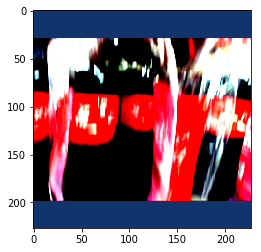

In [69]:
test_caffenet(29)

In [23]:
test_confution_matrix()

Testing file:  /hostname/freiburg_groceries_dataset/splits/test0.txt
{'BEANS': 0, 'CAKE': 1, 'CANDY': 2, 'CEREAL': 3, 'CHIPS': 4, 'CHOCOLATE': 5, 'COFFEE': 6, 'CORN': 7, 'FISH': 8, 'FLOUR': 9, 'HONEY': 10, 'JAM': 11, 'JUICE': 12, 'MILK': 13, 'NUTS': 14, 'OIL': 15, 'PASTA': 16, 'RICE': 17, 'SODA': 18, 'SPICES': 19, 'SUGAR': 20, 'TEA': 21, 'TOMATO_SAUCE': 22, 'VINEGAR': 23, 'WATER': 24}
Data size:  1018
Load training model
1018
Finsh
